In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import yfinance as yf
from pandas_datareader.data import DataReader


In [78]:
import pandas_datareader
pandas_datareader.fred.FredReader("USREC",start='1800',freq='3T').read()

,USREC
DATE,
1854-12-01,1
1855-01-01,0
1855-02-01,0
1855-03-01,0
1855-04-01,0
...,...
2022-11-01,0
2022-12-01,0
2023-01-01,0


In [41]:
# df=yf.download("GE")
# df.head()
df=pd.read_csv('Data/HistoricalVariables.csv',index_col=0)
df['target'] = recessions =  DataReader('USREC', 'fred', start='1800')
df['target'].fillna(method='ffill',inplace=True)
# df=df.fillna(-1)
df=df['1972':]
print(df.shape)
df.head()

(10996, 125)


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,RSXFS,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,CES3000000008,UMCSENT,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,S&P: indust,S&P div yield,S&P PE ratio,target
1972-01-01,4390.518,3977.9,29.79,460625.086,NaN,40.0823,42.2286,40.1674,57.4783,41.609,...,3.57,82.0,524.7,10088.0,29092.0,148.5752,NaN,3.1,18.01,0.0
1972-01-08,4390.518,3977.9,29.79,460625.086,NaN,40.0823,42.2286,40.1674,57.4783,41.609,...,3.57,82.0,524.7,10088.0,29092.0,148.5752,NaN,3.1,18.01,0.0
1972-01-15,4390.518,3977.9,29.79,460625.086,NaN,40.0823,42.2286,40.1674,57.4783,41.609,...,3.57,82.0,524.7,10088.0,29092.0,148.5752,NaN,3.1,18.01,0.0
1972-01-22,4390.518,3977.9,29.79,460625.086,NaN,40.0823,42.2286,40.1674,57.4783,41.609,...,3.57,82.0,524.7,10088.0,29092.0,148.5752,NaN,3.1,18.01,0.0
1972-01-29,4390.518,3977.9,29.79,460625.086,NaN,40.0823,42.2286,40.1674,57.4783,41.609,...,3.57,82.0,524.7,10088.0,29092.0,148.5752,NaN,3.1,18.01,0.0


In [42]:
test_split=round(len(df)*0.20)
df_for_training=df[:"2006"]
df_for_testing=df["2006":]
print('df_for_training shape: ',df_for_training.shape)
print('df_for_testing shape: ',df_for_testing.shape)

df_for_training shape:  (5533, 125)
df_for_testing shape:  (5463, 125)


In [43]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_training_scaled[np.isnan(df_for_training_scaled)] = -1
df_for_testing_scaled=scaler.transform(df_for_testing)
df_for_testing_scaled[np.isnan(df_for_testing_scaled)] = -1


c:\Users\amine\OneDrive\Documents\PFA\.venv\lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
c:\Users\amine\OneDrive\Documents\PFA\.venv\lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [44]:
def createXY(dataset,n_lookback = 60,n_forecast = 3,target_col=-1):
    X = []
    Y = []

    for i in range(n_lookback, len(dataset) - n_forecast + 1):
        X.append(dataset[i - n_lookback: i, 0:dataset.shape[1]])
        Y.append(dataset[i: i + n_forecast,target_col])

    return np.array(X),np.array(Y)
trainX,trainY=createXY(df_for_training_scaled,n_lookback=30,n_forecast=1)
testX,testY=createXY(df_for_testing_scaled,n_lookback=30,n_forecast=1)

In [45]:
df_for_training_scaled.shape

(5533, 125)

In [46]:
trainY.shape

(5503, 1)

In [59]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 30, 64)            48640     
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 61,089
Trainable params: 61,089
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
310/310 [==============================] - 11s 24ms/step - loss: 0.0372 - val_loss: 9.2003e-05
Epoch 2/5
310/310 [==============================] - 7s 22ms/step - loss: 0.0158 - val_loss: 1.6145e-04
Epoch 3/5
310/310 [==============================] - 7s 23ms/step - loss: 0.0115 - val_loss: 6.1443e-05
Epoch 4/5
310/310 [==============================] - 9s 28ms/step - loss: 0.0085 - val_loss: 2.8220e-05
Epoch 5/5
310/310 [==============================] - 9s 29ms/step - loss: 0.0078 - val_loss: 2.2480e-05


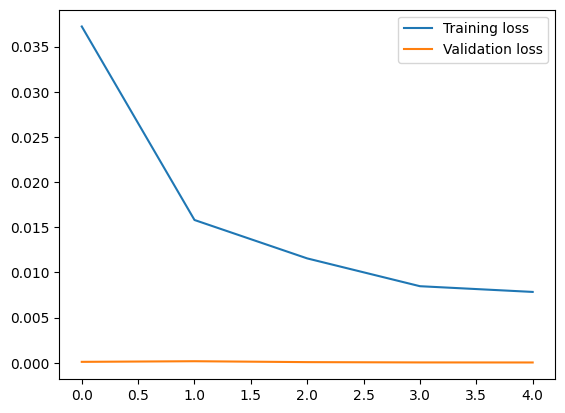

In [60]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [49]:
prediction=model.predict(testX).reshape(-1, 1)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)


170/170 [==============================] - 3s 12ms/step
prediction
 [[0.5000639 ]
 [0.49993604]
 [0.5000072 ]
 ...
 [0.        ]
 [1.        ]
 [0.        ]]

Prediction Shape- (10866, 1)


In [50]:
prediction_train=model.predict(trainX).reshape(-1, 1)
print("prediction_train\n", prediction_train)
print("\nPrediction Shape-",prediction_train.shape)

172/172 [==============================] - 2s 14ms/step
prediction_train
 [[0.4998699 ]
 [0.5001301 ]
 [0.49988467]
 ...
 [0.5001055 ]
 [0.49988672]
 [0.5001132 ]]

Prediction Shape- (11006, 1)


In [72]:
df_for_training[["target"]].index
DataReader('USREC', 'fred', start='1800',freq="Q")

TypeError: DataReader() got an unexpected keyword argument 'freq'

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

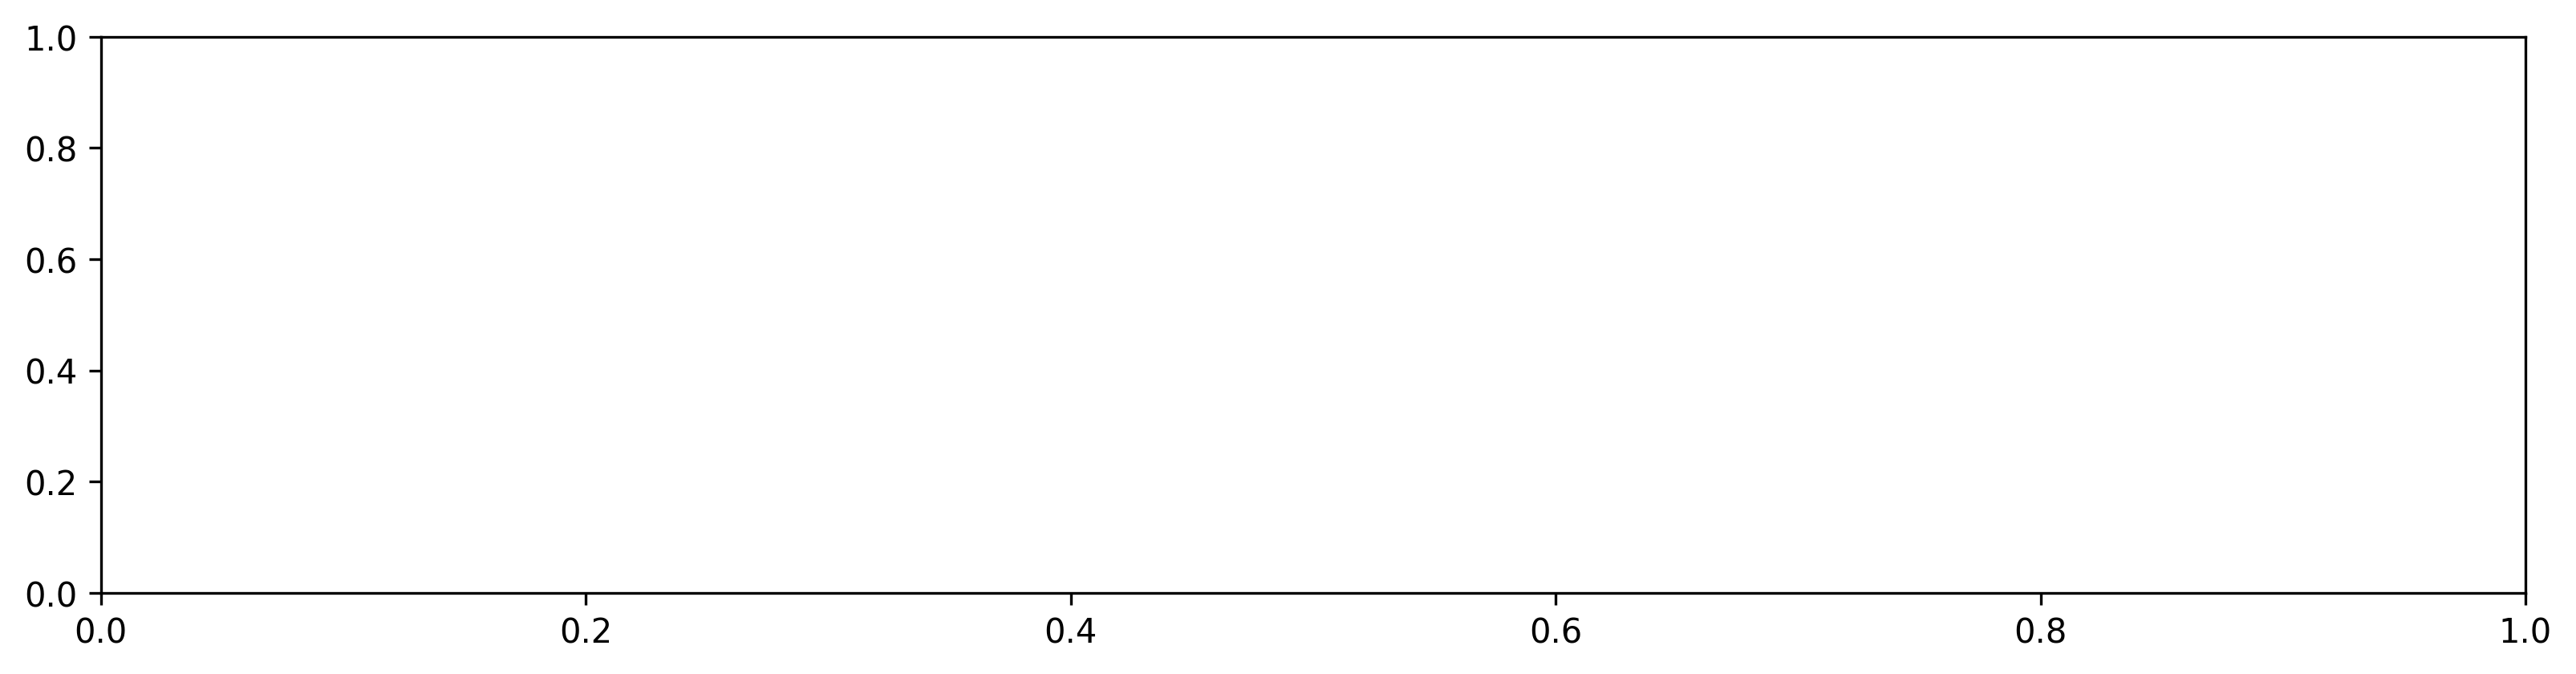

In [63]:
fig, ax = plt.subplots(figsize=(13, 3), dpi=300)
ylim = ax.get_ylim()
ax.fill_between(df_for_training[["target"]].resample('QS').last().squeeze().index, ylim[0]+1e-5, ylim[1]-1e-5, df_for_training[["target"]].resample('QS').last().squeeze(),
                facecolor='k', alpha=0.1)

p1 = plt.Rectangle((0, 0), 1, 1, fc="grey", alpha=0.3)

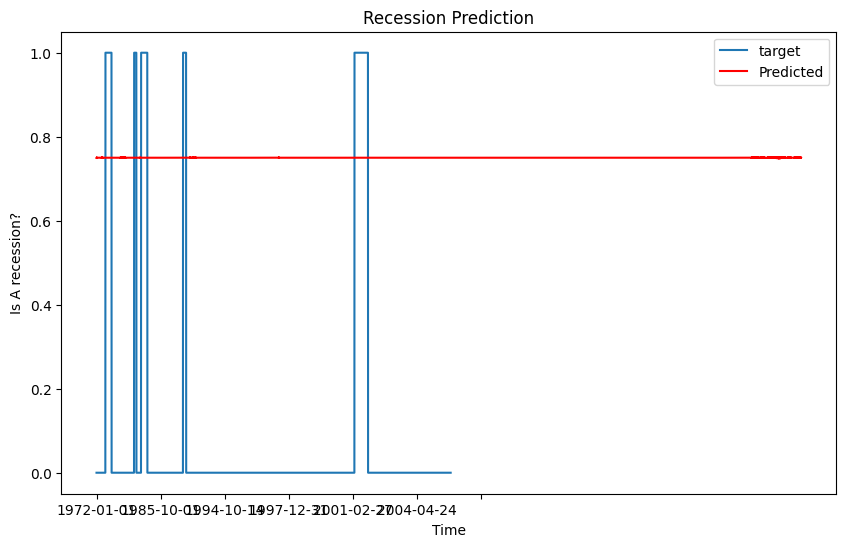

In [ ]:
df_for_training["target"].plot(figsize=(13,3))
plt.plot(*prediction_train, color = 'red', label = 'Predicted')

plt.title('Recession Prediction')
plt.xlabel('Time')
plt.ylabel('Is A recession?')
plt.legend()
plt.show()

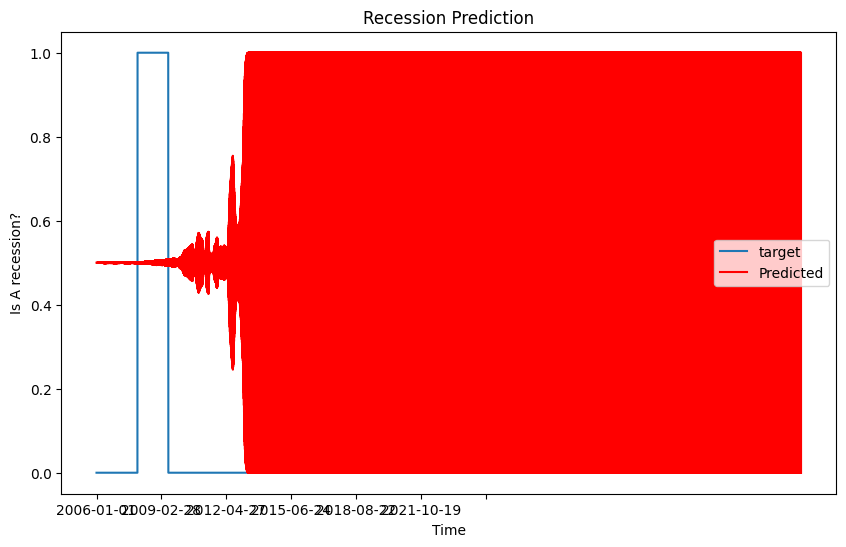

In [52]:
plt.figure(figsize=(10,6))
# plt.plot(df_for_testing["target"], color = 'red', label = 'Real')
df_for_testing["target"].plot()
plt.plot(prediction/prediction.max(), color = 'red', label = 'Predicted')
plt.title('Recession Prediction')
plt.xlabel('Time')
plt.ylabel('Is A recession?')
plt.legend()
plt.show()

In [53]:
df_for_testing["target"].iloc[:-30]

2006-01-01    0.0
2006-01-02    0.0
2006-01-03    0.0
2006-01-04    0.0
2006-01-05    0.0
             ... 
2023-02-25    0.0
2023-02-27    0.0
2023-02-28    0.0
2023-03-01    0.0
2023-03-02    0.0
Name: target, Length: 5433, dtype: float64

In [55]:
from sklearn.metrics import classification_report
print(classification_report(df_for_testing["target"].iloc[:-30], prediction))

ValueError: Found input variables with inconsistent numbers of samples: [5433, 10866]